<a href="https://colab.research.google.com/github/rahvlrawat/Spoiler-Classification-Recommendation-System/blob/main/Spoiler_Classification_%2B_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1> AIM: Using the dataset containing movie and review data to make a spoiler classification model for spoiler reviews and recommendation engine for movies  <h1/>

# Installations/Downloads + Imports


In [2]:
import os

In [3]:
os.system('pip install -q kaggle')
os.system('mkdir ~/.kaggle')
os.system('cp /content/drive/MyDrive/kaggle.json   ~/.kaggle/')
os.system('chmod 600 ~/.kaggle/kaggle.json')
os.system('kaggle datasets download -d  rmisra/imdb-spoiler-dataset')
os.system('kaggle datasets download -d   rtatman/glove-global-vectors-for-word-representation')


0

In [4]:
os.system('unzip  /content/imdb-spoiler-dataset.zip')

0

In [5]:
os.system('unzip /content/glove-global-vectors-for-word-representation.zip')

0

In [6]:
pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 5.2 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
pip install IMDbpy

     |████████████████████████████████| 298 kB 5.3 MB/s 


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import norm
from datetime import datetime
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn import svm
import re
import nltk
import imdb
import pickle


In [9]:
from nltk.corpus import stopwords

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
import tqdm
from tqdm import tqdm
tqdm.pandas()

In [12]:
ia=imdb.IMDb() 

# EDA + Data Preprocessing 

In [ ]:
df_reviews = pd.read_json('/content/IMDB_reviews.json', lines=True)
df_details = pd.read_json('/content/IMDB_movie_details.json', lines=True)

In [ ]:
df_reviews

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"
...,...,...,...,...,...,...,...
573908,8 August 1999,tt0139239,ur0100166,False,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties
573909,31 July 1999,tt0139239,ur0021767,False,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie
573910,20 July 1999,tt0139239,ur0392750,False,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen
573911,11 June 1999,tt0139239,ur0349105,False,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB


In [ ]:
df_reviews.describe()

,rating
count,573913.000000
mean,6.954254
std,2.956295
min,1.000000
25%,5.000000
50%,8.000000
75%,10.000000
max,10.000000


In [ ]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [ ]:
df_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.1+ KB


In [ ]:
df_details.describe()

,rating
count,1572.000000
mean,7.071819
std,0.967966
min,2.400000
25%,6.500000
50%,7.100000
75%,7.800000
max,9.500000


In [ ]:
print(df_reviews.columns)
print(df_details.columns)

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'rating', 'review_summary'],
      dtype='object')
Index(['movie_id', 'plot_summary', 'duration', 'genre', 'rating',
       'release_date', 'plot_synopsis'],
      dtype='object')


df_reviews consists of info about the reviews by the users and  df_details has the info about the movie so we will combine both these tables to get a better formulated table with movie and review info corresponding each user review.

In [ ]:
df_reviews["movie_id"]=df_reviews.movie_id.str.slice(2)


In [ ]:
df_details["movie_id"]=df_details.movie_id.str.slice(2)


In [ ]:
df=pd.merge(df_reviews,df_details,on='movie_id')

As 'movie_id' column is common key in both tables we will merge using this column.

In [ ]:
df.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'rating_x', 'review_summary', 'plot_summary', 'duration', 'genre',
       'rating_y', 'release_date', 'plot_synopsis'],
      dtype='object')

In [ ]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis
0,10 February 2006,11161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,6 September 2000,11161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,3 August 2001,11161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
3,1 September 2002,11161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
4,20 May 2004,11161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."


In [ ]:
df.rename(columns = {'rating_x':'userrating','rating_y':'actualrating'}, inplace = True)

In [ ]:
df['is_spoiler']=df['is_spoiler']+0

Coverting 'is_spoiler' values into *int* values

In [ ]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis
0,10 February 2006,11161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,6 September 2000,11161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,3 August 2001,11161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
3,1 September 2002,11161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
4,20 May 2004,11161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581532 entries, 0 to 581531
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review_date     581532 non-null  object 
 1   movie_id        581532 non-null  object 
 2   user_id         581532 non-null  object 
 3   is_spoiler      581532 non-null  int64  
 4   review_text     581532 non-null  object 
 5   userrating      581532 non-null  int64  
 6   review_summary  581532 non-null  object 
 7   plot_summary    581532 non-null  object 
 8   duration        581532 non-null  object 
 9   genre           581532 non-null  object 
 10  actualrating    581532 non-null  float64
 11  release_date    581532 non-null  object 
 12  plot_synopsis   581532 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 62.1+ MB


In [ ]:
df["review_date"]=pd.to_datetime(df["review_date"])
df["release_date"]=pd.to_datetime(df["release_date"])

Converting both review and release date columns to *datetime* type for better analysis

Let's check  if there are any underlying missing values in the dataset 

In [ ]:
df[df.isna().any(axis=1)==True]

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis


No missing values were found in the dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70e146b650>,
      dtype=object)

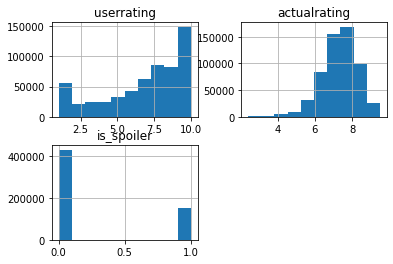

In [ ]:
df[["userrating","actualrating","is_spoiler"]].hist()

Above graph shows distribution of data for the features such as userrating,actualrating and is_spoiler.
All the values here seems reasonable as rating has range 0-10 and is_spoiler can only have either 0 or 1 value.

In [ ]:
print('Total no. of reviews:' , len(df))

Total no. of reviews: 581532


In [ ]:
print("Total no. of users who gave reviews:",df['user_id'].nunique() )

Total no. of users who gave reviews: 263404


In [ ]:
print('Total films in dataset :', df['movie_id'].nunique())

Total films in dataset : 1559


Now lets have a look at data heat map to see if the features bear any correlation wrt eachother 

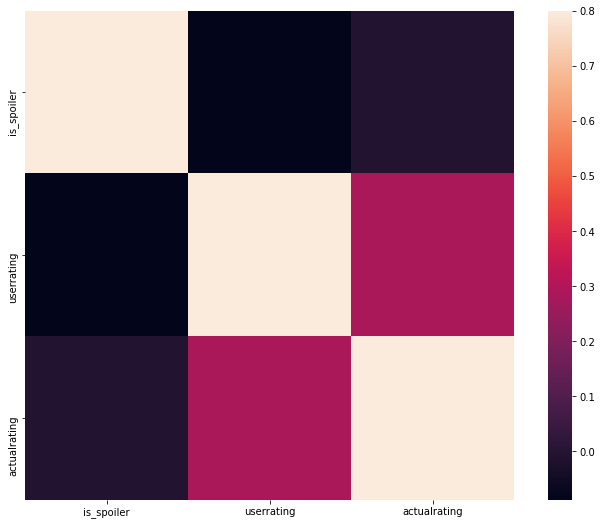

In [ ]:
#correlation matrix
corrmat = df.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

as can be see from the heatmap that there is quite little direct correlation existing  amongst the features 

Lets have a look at distribution of movie's actual rating wrt the reviews containing spoilers and not containing spoilers

Distribution of rating across all movie reviews:


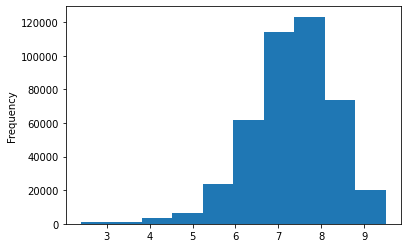

In [ ]:
print("Distribution of rating across all movie reviews:")
df[df["is_spoiler"]==0]['actualrating'].plot(kind='hist')

Distribution of rating across  movie reviews with spoilers:


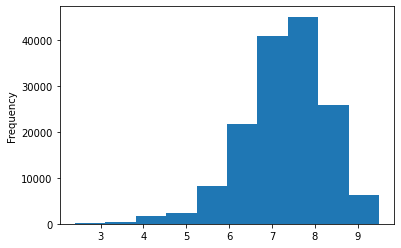

In [ ]:
print("Distribution of rating across  movie reviews with spoilers:")
df[df["is_spoiler"]==1]['actualrating'].plot(kind='hist')

Most of the ratings are concentrated around 6-9  for both reviews either containing spoiler or not.

On similar grounds lets also try to find different insights into the data through some more visualisations 

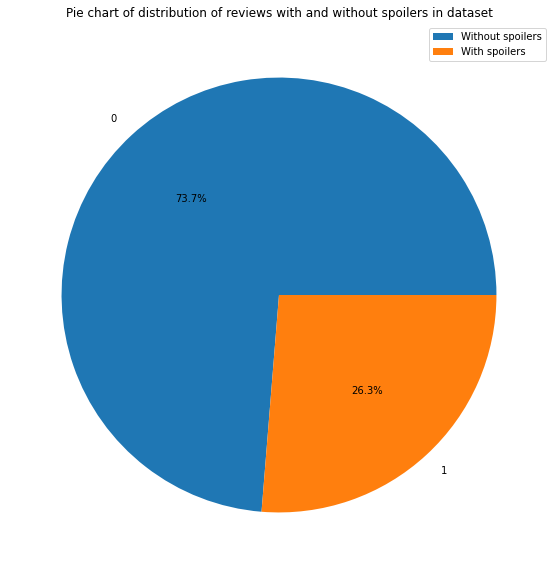

In [ ]:
labels, frequencies = np.unique(df.is_spoiler.values,return_counts = True)
plt.figure(figsize = (10,10))
x=plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title('Pie chart of distribution of reviews with and without spoilers in dataset')
plt.legend(labels=['Without spoilers', 'With spoilers'])

About 70-30  ratio is there between non spoiler and spoiler reviews in the dataset 

Text(0.5, 1.0, 'Pie chart for reviews for top 10 genres:')

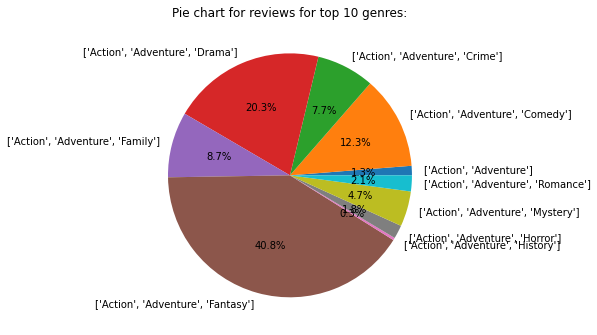

In [ ]:
labels, frequencies = np.unique(df[df["is_spoiler"]==1].genre.values,return_counts = True)
plt.figure(figsize = (8,8))
x=plt.pie(frequencies[:10],labels = labels[:10], autopct = '%1.1f%%')
plt.tight_layout()
plt.title('Pie chart for reviews for top 10 genres:')

These are the top 10 genre sets with most spoiler reviews.This indicates that some movie genres have much more tendency to correspond with spoiler in the reviews than other genres.Using this we will create a qunatitative criteria which will help in classification. 

In [ ]:
df_temp=pd.DataFrame()
df_temp["is_spoiler"]=df["is_spoiler"]
df_temp["days_elapsed"]=abs(df["review_date"]-df["release_date"]).dt.days
df_temp=df_temp.groupby(['is_spoiler', 'days_elapsed']).size().reset_index(name='count').sort_values('days_elapsed')

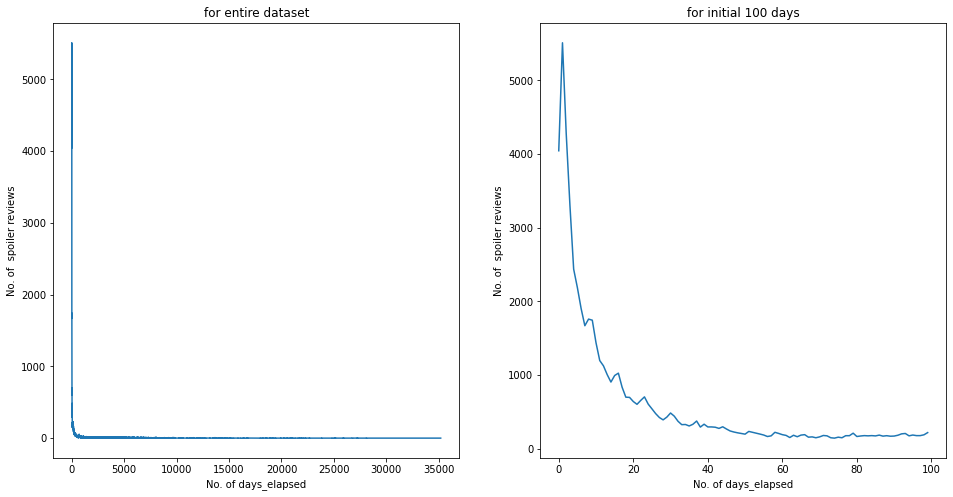

In [ ]:
fig = plt.figure(figsize=(16, 8))


ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(df_temp[df_temp["is_spoiler"]==1]["days_elapsed"].values,df_temp[df_temp["is_spoiler"]==1]["count"].values)
ax1.set_title('for entire dataset')
ax1.set_xlabel('No. of days_elapsed')
ax1.set_ylabel('No. of  spoiler reviews')

ax2.plot(df_temp[df_temp["is_spoiler"]==1]["days_elapsed"][:100].values,df_temp[df_temp["is_spoiler"]==1]["count"][:100].values)
ax2.set_xlabel('No. of days_elapsed')
ax2.set_title('for initial 100 days')
ax2.set_ylabel('No. of  spoiler reviews')

plt.show()

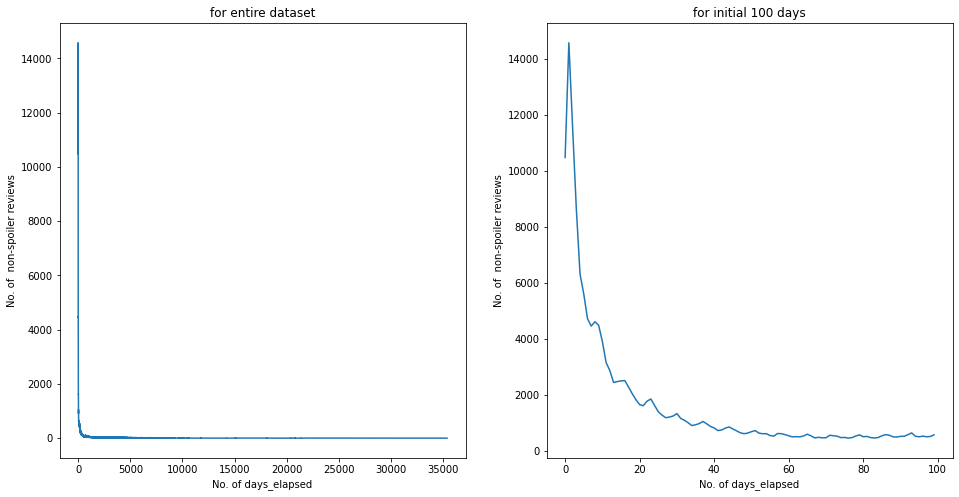

In [ ]:
fig = plt.figure(figsize=(16, 8))


ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(df_temp[df_temp["is_spoiler"]==0]["days_elapsed"].values,df_temp[df_temp["is_spoiler"]==0]["count"].values)
ax1.set_title('for entire dataset')
ax1.set_xlabel('No. of days_elapsed')
ax1.set_ylabel('No. of  non-spoiler reviews')

ax2.plot(df_temp[df_temp["is_spoiler"]==0]["days_elapsed"][:100].values,df_temp[df_temp["is_spoiler"]==0]["count"][:100].values)
ax2.set_xlabel('No. of days_elapsed')
ax2.set_title('for initial 100 days')
ax2.set_ylabel('No. of  non-spoiler reviews')

plt.show()

In [ ]:
df["days_elapsed"]=abs(df["review_date"]-df["release_date"]).dt.days

Above graphs clearly shows most reviews for a movie are around the time of the release of the movie and as it  moves away from the release date after some days the review logging for the respective movie also depreciates.Same trend can be seen for the reviews with spoilers.

In [ ]:
spoilermovies=df[df['is_spoiler']==1].movie_id.value_counts()[:20].index.to_list()
pivot_df=df.groupby(['is_spoiler', 'movie_id']).size().reset_index(name='count').sort_values('count')
pivot_df=pivot_df[pivot_df["movie_id"].isin(spoilermovies)]
pivot_df=pivot_df.pivot(index='movie_id',  columns='is_spoiler', values='count')
pivot_df=pivot_df.fillna(0)

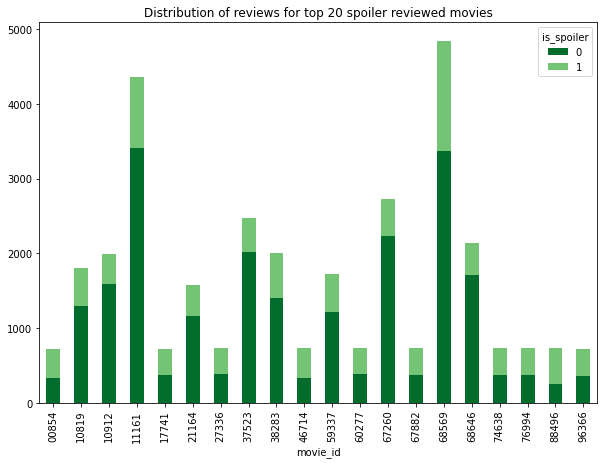

In [ ]:
colors = ["#006D2C","#74C476"]
pivot_df.plot.bar(stacked=True, color=colors, figsize=(10,7),title="Distribution of reviews for top 20 spoiler reviewed movies")


Based on graph it can be seen that some movies have more chances  of having spoiler reviews when compared with others that can be attributed to various factors beyond the scope of our current application so for the time being we can use this criteria of tendency of movie to have spoilers for spoiler classification.

In [ ]:
spoilermovies=df[df['is_spoiler']==1].user_id.value_counts()[:20].index.to_list()
pivot_df=df.groupby(['is_spoiler', 'user_id']).size().reset_index(name='count').sort_values('count')
pivot_df=pivot_df[pivot_df["user_id"].isin(spoilermovies)]
pivot_df=pivot_df.pivot(index='user_id',  columns='is_spoiler', values='count')
pivot_df=pivot_df.fillna(0)

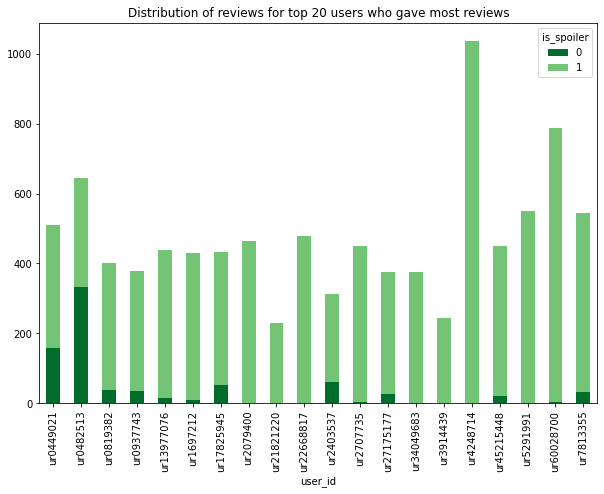

In [ ]:
colors = ["#006D2C","#74C476"]
pivot_df.plot.bar(stacked=True, color=colors, figsize=(10,7),title="Distribution of reviews for top 20 users who gave most reviews")

As can be seen from the above graphs most of the top users have mostly given more spoiler reviews when compared to non spoiler ones.
This indicates that some users are more likely to give spoiler reviews than others.Same as movie tendency for reviews we will use this user tendency for giving spoiler reviews for help in classification,

In [ ]:
df.groupby(['movie_id']).size().reset_index(name='count').sort_values('count')

,movie_id,count
30,01265,4
1477,94822,11
218,07719,12
1157,68216,13
32,01301,15
...,...,...
1163,68646,2137
779,37523,2480
1145,67260,2729
311,11161,4361


As can be seen from the above data some movie have much more reviews than other movies which is  a good indicator of popularity of the movie.

In [ ]:
df_temp2=pd.DataFrame()
df_temp2['word_count'] = df['review_text'].apply(lambda text: len(text.split(' ')))
df_temp2["is_spoiler"]=df.is_spoiler

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


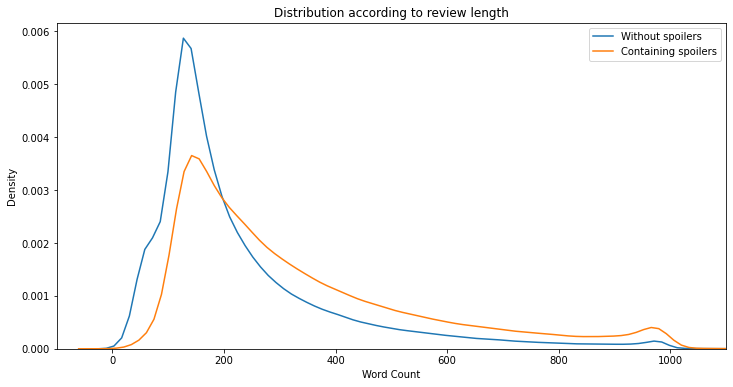

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(df_temp2[df_temp2['is_spoiler'] == False]['word_count'], hist=False, label='Without spoilers')
sns.distplot(df_temp2[df_temp2['is_spoiler'] == True]['word_count'], hist=False, label='Containing spoilers')
plt.legend()
plt.xlim([-100, 1100])
plt.xlabel('Word Count')
plt.title('Distribution according to review length')
plt.show()

This clearly indicates that word count for reviews containing spoilers are mostly larger as compared to non-spoiler reviews

In [ ]:
df["word_count"]=df['review_text'].apply(lambda text: len(text.split(' ')))

In [ ]:
df_temp2["review_text"]=df["review_text"].str.lower()

In [ ]:
df_temp2["spoiltext"]=df_temp2.review_text.str.contains("spoil")+0

In [ ]:
df_temp2.review_text.str.contains("dies").value_counts()

False    546690
True      34842
Name: review_text, dtype: int64

In [ ]:
df_temp2["spoiltext"].value_counts()

0    543120
1     38412
Name: spoiltext, dtype: int64

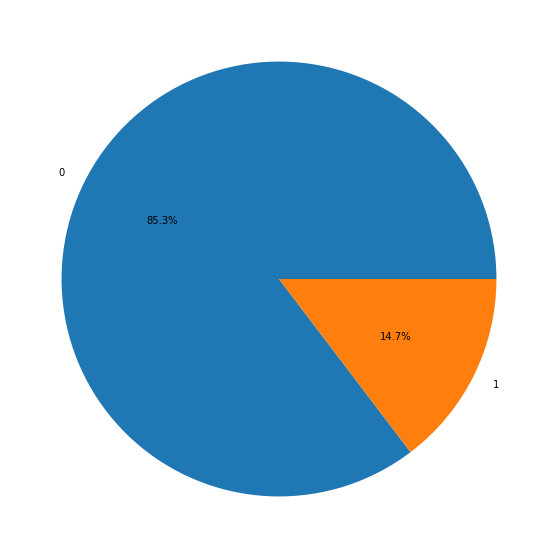

In [ ]:
labels, frequencies = np.unique(df_temp2[df_temp2["is_spoiler"]==1].spoiltext.values,return_counts = True)
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

While the ratio itself isn't much appreciable but this can be a great criteria along with some other words that all spoiler reviews may contain frequently.

Lets further evaluate reviews using some NLP to find sembelance to spoilers  with the way they are written.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords=set(stopwords.words('english'))
stopwords_dict=Counter(stopwords)
def preprocesstext(review):
    review=review.lower()
    review=re.sub('[^a-zA-Z]',' ',review)
    words=review.split()
    word=[word for word in words if word not in stopwords_dict]
    review=" ".join(words)
    return review
df_temp2.review_text=df_temp2.review_text.apply(preprocesstext)

In [ ]:
df_temp2.review_text

0         in its oscar year shawshank redemption written...
1         the shawshank redemption is without a doubt on...
2         i believe that this film is the best story eve...
3         yes there are spoilers here this film has had ...
4         at the heart of this extraordinary movie is a ...
                                ...                        
581527    go is wise fast and pure entertainment assembl...
581528    well what shall i say this one s fun at any ra...
581529    go is the best movie i have ever seen and i ve...
581530    call this teenage version of pulp fiction what...
581531    why was this movie made no doubt to sucker in ...
Name: review_text, Length: 581532, dtype: object

In [ ]:
Counter(" ".join(df_temp2["review_text"][:200000]).split()).most_common(100)

[('the', 3276372),
 ('and', 1626441),
 ('a', 1430258),
 ('of', 1390195),
 ('to', 1271157),
 ('is', 1069559),
 ('it', 941039),
 ('i', 868774),
 ('in', 855575),
 ('that', 718976),
 ('this', 656909),
 ('s', 576457),
 ('movie', 487551),
 ('as', 444053),
 ('was', 442470),
 ('for', 419830),
 ('with', 415144),
 ('film', 410990),
 ('but', 405011),
 ('you', 348294),
 ('t', 311905),
 ('he', 308440),
 ('his', 305103),
 ('not', 302096),
 ('on', 281281),
 ('are', 273357),
 ('be', 259339),
 ('have', 251170),
 ('one', 247405),
 ('all', 244274),
 ('by', 205126),
 ('so', 204148),
 ('an', 200017),
 ('they', 195124),
 ('at', 192851),
 ('from', 191718),
 ('like', 188096),
 ('who', 174172),
 ('just', 172327),
 ('there', 171840),
 ('has', 168171),
 ('about', 164407),
 ('what', 161912),
 ('or', 152874),
 ('more', 152262),
 ('story', 149509),
 ('out', 144484),
 ('can', 143977),
 ('if', 143209),
 ('good', 139184),
 ('time', 137318),
 ('my', 131958),
 ('very', 130151),
 ('some', 130066),
 ('when', 129206),
 ('m

In [ ]:
df["spoiltext"]=df.review_text.str.contains("spoil")+0

Opposed to the intution the most common words as  can be seen bear no semantic role towards indicating a spoiler.Despite of this it is easy to infer that if  "spoiler" word is present in the review than its very likely to be a spoiler review so we will include this as a criteria.

In [ ]:
df_temp2=pd.DataFrame()

In [ ]:
df_temp2["year"]=df["review_date"].dt.year
df_temp2["is_spoiler"]=df["is_spoiler"]

In [ ]:
pivot_df=df_temp2.groupby(["year","is_spoiler"]).size().reset_index(name='count').sort_values('count')
pivot_df=pivot_df.pivot(index='year',  columns='is_spoiler', values='count')
pivot_df=pivot_df.fillna(0)[:-1]

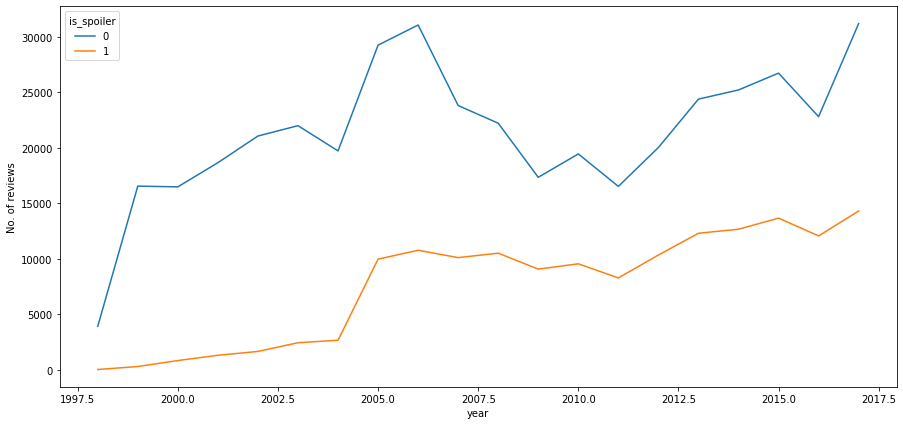

In [ ]:
pivot_df.plot(ylabel="No. of reviews",figsize=(15,7))

Nothing could make it more clear than this graph on why we need this project.Over the years with the accessebility to give reviews the trend of spoiler reviews has only increased and to keep the review sections spoil-free  for the users it is important to come up with a good tool to curb this as much as possible.

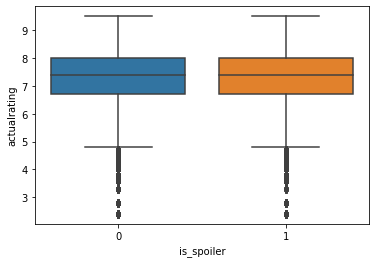

In [ ]:
sns.boxplot(x= df.is_spoiler,y=df.actualrating)

Almost the same  actualrating  data  variance for both kind of reviews .

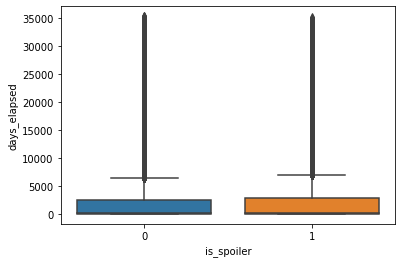

In [ ]:
sns.boxplot(x= df.is_spoiler,y=df.days_elapsed)

Clearly days_elapsed also have same kind of data distribution for both cases but in this case there are a lot of outliers.

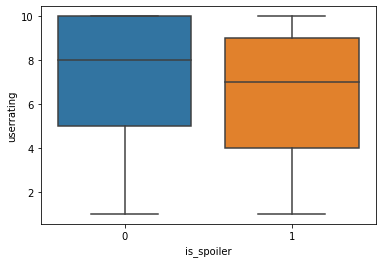

In [ ]:
sns.boxplot(x= df.is_spoiler,y=df.userrating)

User ratings for ratings with spoiler reviews are somewhat lower  overall as compared with without spoilers.

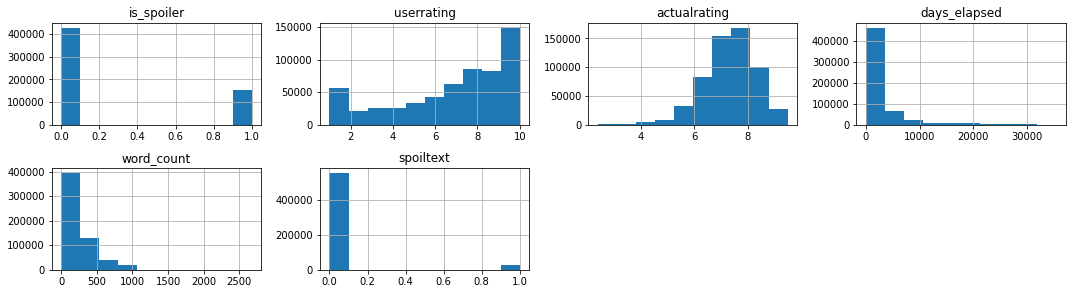

In [ ]:
df.hist(layout=(5,4), figsize=(15,10),)
plt.tight_layout()
plt.show()

Above fig helps in understanding the disrtibution of various features in the dataset where some new features have been added to help in the predictions.

In [ ]:
df.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'userrating', 'review_summary', 'plot_summary', 'duration', 'genre',
       'actualrating', 'release_date', 'plot_synopsis', 'days_elapsed',
       'word_count', 'spoiltext'],
      dtype='object')

After exploratory analysis  some key insights were gained which are as following:-


*   Some users,movies and genres have greater chances of containing reviews with spoilers so to exploit this  can create parameter corresponding each feature mentioned above where  assign every movie,user,genre pool a certain ratio attributing to its affinity for spoilers

*  Some spoilers will clearly contain the word "spoiler" indicative of it containing the spoilers so will assign a feature which tells us if review text for respective row contains the word "spoiler" or not 

*   The period  b/w review_date and release_date doesn't seem to be having any difference for spoiler and non spoiler reviews as evident from respective boxplot however it also holds information and might be helpful so will later try to make predictions both with and without it and compare the results

*   Can  also exploit the word count of reviews as a feature for the predictions 

* As can be observed  both review and corresponding plot summary so 
another good indicator for spoilers will be how close a review is to its plot synopsis 








In [ ]:
len(df)

581532

# Introducing new features based on observations from EDA

## Movie spoiler ratio(MSR)

For every movie  will compare its no. of reviews with spoilers to total no. of reviews for the movie  and assign this ratio as ***Movie spoiler ratio  aka msr***

In [ ]:
total_spoilers= df.groupby(by='movie_id').is_spoiler.agg(['sum']).reset_index().rename(columns={'sum':'total_spoilers'})

In [ ]:
total_movies = df.groupby(by='movie_id').movie_id.agg(['count']).reset_index().rename(columns={'count':'total_movies'})

In [ ]:
msr = pd.merge(total_spoilers,total_movies, on='movie_id')

In [ ]:
msr['msr']=msr.total_spoilers/msr.total_movies

In [ ]:
msr.head()

,movie_id,total_spoilers,total_movies,msr
0,00029,20,61,0.327869
1,00039,68,304,0.223684
2,00050,7,27,0.259259
3,00054,31,98,0.316327
4,00080,193,603,0.320066


In [ ]:
msr.drop(['total_spoilers','total_movies'], axis=1, inplace=True)

In [ ]:
df=pd.merge(df,msr,on='movie_id')

In [ ]:
df

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,word_count,spoiltext,msr
0,2006-02-10,11161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137,843,0,0.219216
1,2000-09-06,11161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2154,223,0,0.219216
2,2001-08-03,11161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2485,250,0,0.219216
3,2002-09-01,11161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2879,766,0,0.219216
4,2004-05-20,11161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",3506,829,0,0.219216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581527,1999-08-08,39239,ur0100166,0,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",121,52,0,0.056338
581528,1999-07-31,39239,ur0021767,0,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",113,54,0,0.056338
581529,1999-07-20,39239,ur0392750,0,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",102,202,0,0.056338
581530,1999-06-11,39239,ur0349105,0,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",63,89,0,0.056338


##User Spoiler Ratio (USR)

For every user  will compare its no. of reviews with spoilers to total no. of reviews from the user and assign this ratio as ***User spoiler ratio  aka  usr***

In [ ]:
total_user_spoilers = df.groupby(by='user_id').is_spoiler.agg(['sum']).reset_index().rename(columns={'sum':'total_user_spoilers'})


In [ ]:
total_users = df.groupby(by='user_id').user_id.agg(['count']).reset_index().rename(columns={'count':'total_users'})


In [ ]:
usr = pd.merge(total_user_spoilers,total_users, on='user_id')

In [ ]:
usr['usr']=usr.total_user_spoilers / usr.total_users

In [ ]:
usr.drop(['total_user_spoilers','total_users'], axis=1,inplace=True)

In [ ]:
df= pd.merge(df, usr, on='user_id')

## Genre Spoiler Ratio

For differenet genres there will be diffrent likelihood of having spoilers so i'll assign ratio similar to the way of USR and MSR for each genre category but for that first i'll introduce dummy columns for each major genre and assign values corresponding to each movie.

In [ ]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,word_count,spoiltext,msr,usr
0,2006-02-10,11161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137,843,0,0.219216,0.6
1,2006-03-19,44084,ur1898687,0,"Starring: Christian Bale, Willem Dafoe, Chloë ...",8,"Worth seeing, if only for the post-viewing dis...","Patrick Bateman is handsome, well educated and...",1h 42min,"[Crime, Drama]",7.6,2000-04-14,A white background. Red drops begin to fall pa...,2165,526,1,0.274725,0.6
2,2006-02-10,98203,ur1898687,1,"Eminem's ""semi-autobiographical"" rap movie. Do...",7,Better than it needed to be.,This is the inspiring captivating story of the...,1h 50min,"[Drama, Music]",7.1,2002-11-08,"It's 1995. Jimmy ""B-Rabbit"" Smith Jr. (Eminem)...",1190,467,0,0.164456,0.6
3,2006-02-10,19061,ur1898687,0,The grass is so green / The sky is so blue / S...,9,An immediate classic that works on both a visu...,United Press International journalist Will Blo...,2h 5min,"[Adventure, Drama, Fantasy]",8.0,2004-01-09,"Edward Bloom (Albert Finney), a charismatic te...",763,320,0,0.158416,0.6
4,2006-02-10,77092,ur1898687,1,There are a few signs heading into Mean Girls ...,7,"A smart, but flawed, look at high school life","Her parents being zoologists, homeschooled Cad...",1h 37min,[Comedy],7.0,2004-04-30,Cady (Lindsay Lohan) is the 16-year-old home-s...,651,438,0,0.222472,0.6


In [ ]:
genres=np.unique(np.array(' '.join(df_details.genre.str.join(' ')).split()))

In [ ]:
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western'], dtype='<U9')

In [ ]:
genre_df=pd.DataFrame()

In [ ]:
for i in genres:
    genre_df[i.lower()]=0

In [ ]:
genre_df

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,film-noir,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western


In [ ]:
for i,data in df_details.iterrows():
    #Assigns details pertaining to a movie to a variable
    details=df_details[df_details.movie_id==data['movie_id']]
    genre_df.at[i,'movie_id']=data['movie_id']
    for genre in genres:
        #Checks if movie belongs to the genre or not 
        genre_df.at[i,genre.lower()]=int(genre in details['genre'].tolist()[0])

In [ ]:
genre_df

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,film-noir,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western,movie_id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,05112
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04975
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,43655
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,40897
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,89879
1568,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23811
1569,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13056
1570,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04014/


In [ ]:
df_temp= pd.merge(df, genre_df, on="movie_id")

In [ ]:
df_temp

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,word_count,spoiltext,msr,usr,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,film-noir,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western
0,2006-02-10,11161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137,843,0,0.219216,0.600000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000-09-06,11161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2154,223,0,0.219216,0.250000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2001-08-03,11161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2485,250,0,0.219216,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2002-09-01,11161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",2879,766,0,0.219216,0.461538,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2004-05-20,11161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",3506,829,0,0.219216,0.134752,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596779,2017-12-22,67800,ur25307523,0,Aruvi is a waterfall of human mixed-emotions p...,10,Waterfall of human mixed-emotions,A gentle girl born and brought up amidst the e...,2h 10min,[Drama],9.5,2017-12-15,,7,226,0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596780,2017-12-22,67800,ur83510976,0,Definitely a class apart. Excellent work by th...,10,One of the best movies in Indian cine Industry,A gentle girl born and brought up amidst the e...,2h 10min,[Drama],9.5,2017-12-15,,7,56,0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596781,2017-12-21,67800,ur54551299,0,Aruvi will be one of the iconic movie of Tamil...,9,Aruvi - A Masterpiece,A gentle girl born and brought up amidst the e...,2h 10min,[Drama],9.5,2017-12-15,,6,336,0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596782,2017-12-19,67800,ur48291086,0,"Rolling Sirrrrr ,\nSuch a hard hitting and gut...",10,Aruvi - Ever Best in Indian Cinema,A gentle girl born and brought up amidst the e...,2h 10min,[Drama],9.5,2017-12-15,,4,109,0,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
e = 0.001
gsr = np.zeros(len(genres))
for i,g in enumerate(genres):
    # i.e. total no. of reviews with spoiler belonging to a genre /total no. of reviews of movie genre
    gsr[i] = df_temp[(df_temp.is_spoiler==1) & (df_temp[g.lower()]==1)].shape[0] / (df_temp[df_temp[g.lower()]==1].shape[0]+e)

<h1>Based on (total no. of reviews with spoiler belonging to a genre /total no. of reviews of movie genre) we will assign gsr to individual genres and then combine these gsr for individual genres to get total gsr for a movie as movie items contain more than one genre<h2/>

In [ ]:
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western'], dtype='<U9')

In [ ]:
gsr

array([0.28213068, 0.28470852, 0.25193949, 0.24122044, 0.21560115,
       0.24345536, 0.25690608, 0.27273799, 0.28204767, 0.27247333,
       0.23550389, 0.29679866, 0.20991318, 0.18343476, 0.28947245,
       0.23947442, 0.31041596, 0.23998089, 0.28119447, 0.24305825,
       0.26398324])

In [ ]:
genre_ratio=dict(zip(genres,gsr))

In [ ]:
genre_ratio

{'Action': 0.28213067999518304,
 'Adventure': 0.28470852450272033,
 'Animation': 0.2519394862381463,
 'Biography': 0.24122043505048255,
 'Comedy': 0.21560115258984852,
 'Crime': 0.24345535782508523,
 'Drama': 0.25690607646427394,
 'Family': 0.272737990498101,
 'Fantasy': 0.28204767326583147,
 'Film-Noir': 0.2724733263688853,
 'History': 0.23550389210774977,
 'Horror': 0.29679865653555637,
 'Music': 0.20991317840187546,
 'Musical': 0.18343475552753843,
 'Mystery': 0.2894724471206937,
 'Romance': 0.239474420468319,
 'Sci-Fi': 0.3104159578967337,
 'Sport': 0.2399808874068598,
 'Thriller': 0.2811944663141321,
 'War': 0.24305824764780526,
 'Western': 0.26398323784850525}

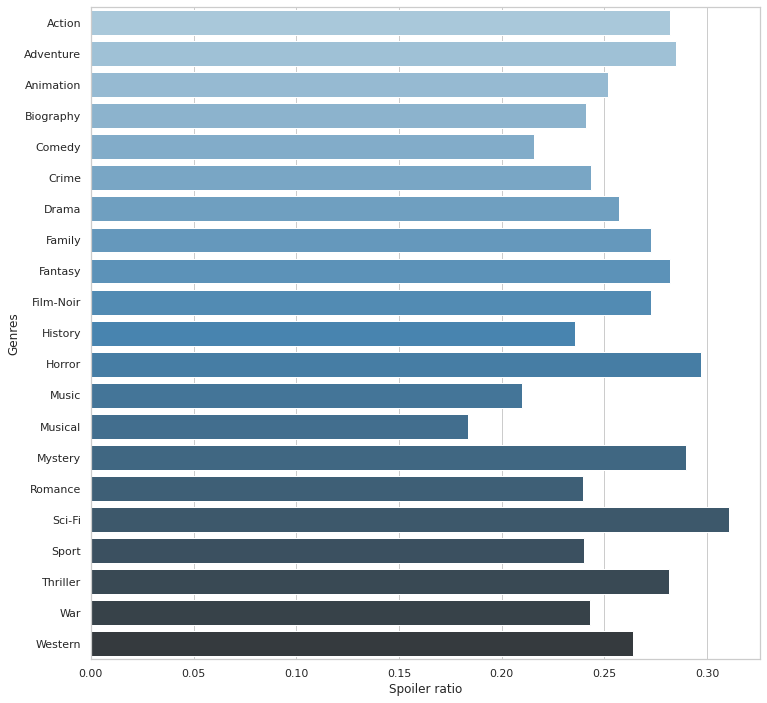

In [ ]:
plt.figure(figsize=(12,12))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=gsr,y=genres,palette="Blues_d")
ax.set(xlabel="Spoiler ratio",ylabel="Genres");
plt.show();

In [ ]:
def genrespoilerratio(list):
  value=0
  for i in list:
    value+=genre_ratio[i]
  return value   

In [ ]:
df['gsr'] = pd.merge(df,df_details.drop(['genre'],axis=1),on="movie_id").genre.progress_apply(genrespoilerratio)

100%|██████████| 596784/596784 [00:01<00:00, 444419.70it/s]


In [ ]:
df

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,word_count,spoiltext,msr,usr,gsr
0,2006-02-10,11161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137,843,0,0.219216,0.6,0.500361
1,2006-03-19,44084,ur1898687,0,"Starring: Christian Bale, Willem Dafoe, Chloë ...",8,"Worth seeing, if only for the post-viewing dis...","Patrick Bateman is handsome, well educated and...",1h 42min,"[Crime, Drama]",7.6,2000-04-14,A white background. Red drops begin to fall pa...,2165,526,1,0.274725,0.6,0.500361
2,2006-02-10,98203,ur1898687,1,"Eminem's ""semi-autobiographical"" rap movie. Do...",7,Better than it needed to be.,This is the inspiring captivating story of the...,1h 50min,"[Drama, Music]",7.1,2002-11-08,"It's 1995. Jimmy ""B-Rabbit"" Smith Jr. (Eminem)...",1190,467,0,0.164456,0.6,0.500361
3,2006-02-10,19061,ur1898687,0,The grass is so green / The sky is so blue / S...,9,An immediate classic that works on both a visu...,United Press International journalist Will Blo...,2h 5min,"[Adventure, Drama, Fantasy]",8.0,2004-01-09,"Edward Bloom (Albert Finney), a charismatic te...",763,320,0,0.158416,0.6,0.500361
4,2006-02-10,77092,ur1898687,1,There are a few signs heading into Mean Girls ...,7,"A smart, but flawed, look at high school life","Her parents being zoologists, homeschooled Cad...",1h 37min,[Comedy],7.0,2004-04-30,Cady (Lindsay Lohan) is the 16-year-old home-s...,651,438,0,0.222472,0.6,0.500361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581527,1999-08-18,39239,ur0419756,0,I think this movie was under-appreciated by Am...,10,innovative and rockin'...I love Go!,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",131,45,0,0.056338,0.0,0.711982
581528,1999-08-14,39239,ur0415521,0,This type of movie is one that I would not ord...,9,GO see it!,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",127,89,0,0.056338,0.0,0.711982
581529,1999-08-08,39239,ur0100166,0,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",121,52,0,0.056338,0.0,0.711982
581530,1999-07-20,39239,ur0392750,0,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen,"Told from three perspectives, a story of a bun...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",102,202,0,0.056338,0.0,0.711982


##  Matching Text from reviews with plot summary 

 will find distance between plot summary and  the corresponding reviews.Lesser the distance more is the probability of them containing same information i.e. spoilers . So in order to do this  will first preprocess the text to remove all non alphabetical characters and stop words from the review_text and plot summary and then using glove embeddings will filnd distance between them .

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
stopwords_dict=Counter(stopwords)
def preprocesstext(text):
    text=text.lower()
    text=re.sub('[^a-zA-Z]',' ',text)
    words=text.split()
    word=[word for word in words if word not in stopwords_dict]
    text=" ".join(words)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.review_text=df.review_text.apply(preprocesstext)
df.plot_summary=df.plot_summary.apply(preprocesstext)


Using glove-global-vectors for words.These pre-trained embeddings are used  to quantify word co-occurrence (which also captures some aspects of word meaning). This dataset contains 50-dimensional, 100-dimensional and 200-dimensional pre trained word vectors.Here i'll be using 50 dimensional one.

In [ ]:
#Saving the words and their corresponding vectors in  a dictionary
embeddings=dict()
f=open('/content/glove.6B.50d.txt')
for i in f: 
    values=i.split()
    word=values[0]
    cofss = np.asarray(values[1:], dtype='float32')
    embeddings[word]=cofss
f.close()    

In [ ]:
def getAvgWordEmbedding(text):
    words = text.split()
    n = 0
    sumEmbed = np.zeros(50)
    # because 50 dim of word vectors
    
    for word in words:
        if word in embeddings:
            sumEmbed += embeddings[word]
            n += 1
    
    avgEmbed = sumEmbed / n
    return avgEmbed
    
def Dist(e1, e2):
    return np.sum(np.square(e1-e2), axis = 1)

In [ ]:
plot_embed = df.plot_summary.progress_apply(getAvgWordEmbedding)

100%|██████████| 581532/581532 [02:09<00:00, 4489.93it/s]


In [ ]:
review_embed = df.review_text.progress_apply(getAvgWordEmbedding)

In [ ]:
df['distance_plot']=Dist(np.stack(review_embed),np.stack(plot_embed))

# Saving the processed dataset for future use


In [ ]:
df.to_csv('/content/drive/MyDrive/Spoiler_alert_model/processed_data/processed_data.csv',index=False)

#Preparing  Train / Valid / Test Sets


In [13]:
df = pd.read_csv('/content/drive/MyDrive/Spoiler_alert_model/processed_data/processed_data.csv')

In [14]:
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,word_count,spoiltext,msr,usr,gsr,distance_plot
0,2006-02-10,11161,ur1898687,1,in its oscar year shawshank redemption written...,10,A classic piece of unforgettable film-making.,chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",4137,843,0,0.219216,0.6,0.500361,0.670662
1,2006-03-19,44084,ur1898687,0,starring christian bale willem dafoe chlo sevi...,8,"Worth seeing, if only for the post-viewing dis...",patrick bateman is handsome well educated and ...,1h 42min,"['Crime', 'Drama']",7.6,2000-04-14,A white background. Red drops begin to fall pa...,2165,526,1,0.274725,0.6,0.500361,0.529877
2,2006-02-10,98203,ur1898687,1,eminem s semi autobiographical rap movie do i ...,7,Better than it needed to be.,this is the inspiring captivating story of the...,1h 50min,"['Drama', 'Music']",7.1,2002-11-08,"It's 1995. Jimmy ""B-Rabbit"" Smith Jr. (Eminem)...",1190,467,0,0.164456,0.6,0.500361,0.287624
3,2006-02-10,19061,ur1898687,0,the grass is so green the sky is so blue spect...,9,An immediate classic that works on both a visu...,united press international journalist will blo...,2h 5min,"['Adventure', 'Drama', 'Fantasy']",8.0,2004-01-09,"Edward Bloom (Albert Finney), a charismatic te...",763,320,0,0.158416,0.6,0.500361,0.636278
4,2006-02-10,77092,ur1898687,1,there are a few signs heading into mean girls ...,7,"A smart, but flawed, look at high school life",her parents being zoologists homeschooled cady...,1h 37min,['Comedy'],7.0,2004-04-30,Cady (Lindsay Lohan) is the 16-year-old home-s...,651,438,0,0.222472,0.6,0.500361,0.392562


In [15]:
train,val = train_test_split(df, test_size=0.2, stratify=df["is_spoiler"])


In [16]:
train,test=train_test_split(train, test_size=0.2, stratify=train["is_spoiler"])


# Read  Train/Valid/Sets 

In [17]:
train.columns

Index(['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text',
       'userrating', 'review_summary', 'plot_summary', 'duration', 'genre',
       'actualrating', 'release_date', 'plot_synopsis', 'days_elapsed',
       'word_count', 'spoiltext', 'msr', 'usr', 'gsr', 'distance_plot'],
      dtype='object')

In [18]:
from sklearn.preprocessing import Normalizer,StandardScaler

In [19]:
columns=['days_elapsed','word_count','spoiltext','usr','msr','gsr','distance_plot','actualrating']


In [20]:
x_train = train[columns].fillna(0)
x_train=Normalizer().fit_transform(x_train)
y_train=train['is_spoiler'].values

In [21]:
x_test = val[columns].fillna(0)
x_test = Normalizer().fit_transform(x_test)
y_test=val['is_spoiler'].values

# Logistic Regression 

In [22]:
logistic= LogisticRegression(random_state=42, max_iter=1000) 
logistic.fit(x_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
y_pred=logistic.predict(x_test)

In [24]:
print(logistic.score(x_test, y_test))

0.7372127215042946


In [25]:
print('AUC: ', roc_auc_score(y_test, y_pred))


AUC:  0.5000163585800752


In [26]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85     85742
           1       1.00      0.00      0.00     30565

    accuracy                           0.74    116307
   macro avg       0.87      0.50      0.42    116307
weighted avg       0.81      0.74      0.63    116307

[[85742     0]
 [30564     1]]


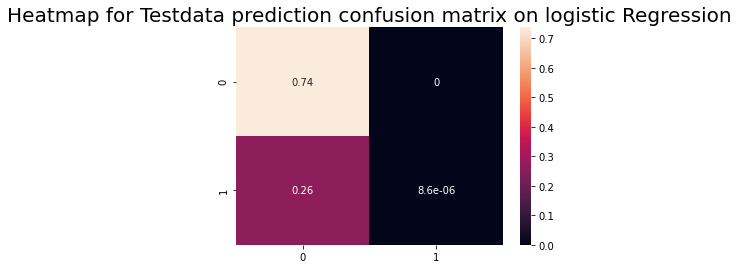

In [27]:
plt.title("Heatmap for Testdata prediction confusion matrix on logistic Regression", fontsize =20)
sns.heatmap(confusion_matrix(y_test,y_pred)/np.sum(confusion_matrix(y_test, y_pred)), annot=True)

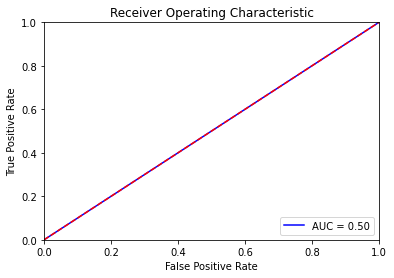

In [28]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# KNN


In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
train_score = []
test_score = []
k_vals = []

for k in range(1, 15):
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    
    tr_score = knn.score(x_train, y_train)
    train_score.append(tr_score)
    
    te_score = knn.score(x_test, y_test)
    test_score.append(te_score)

In [36]:
max_test_score = max(test_score)
test_scores_ind = [i for i, v in enumerate(test_score) if v == max_test_score]
print('Max test score {} and k = {}'.format(max_test_score * 100, list(map(lambda x: x + 1, test_scores_ind))))

Max test score 89.01699811705228 and k = [5]


In [37]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(3)

knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.8885191776935181

In [38]:

y_pred = knn.predict(x_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,81661,4081,85742
1,8885,21680,30565
All,90546,25761,116307


In [39]:
print('AUC: ', roc_auc_score(y_test, y_pred))


AUC:  0.8308558774295564


In [40]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93     85742
           1       0.84      0.71      0.77     30565

    accuracy                           0.89    116307
   macro avg       0.87      0.83      0.85    116307
weighted avg       0.89      0.89      0.89    116307

[[81661  4081]
 [ 8885 21680]]


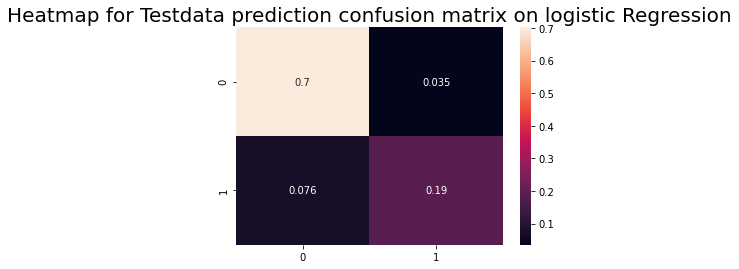

In [41]:
plt.title("Heatmap for Testdata prediction confusion matrix on logistic Regression", fontsize =20)
sns.heatmap(confusion_matrix(y_test,y_pred)/np.sum(confusion_matrix(y_test, y_pred)), annot=True)

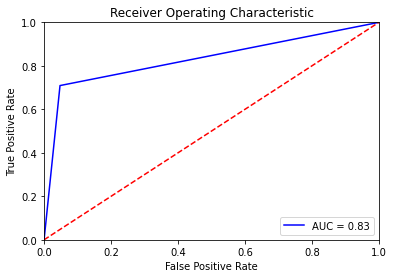

In [42]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



# Random Forest 

##Finding best hyperparameters


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 150, num = 15)]
max_depth = [int(x) for x in np.linspace(40, 150, num = 15)]
param_dist = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
}
rf_tuned = RandomForestClassifier(random_state = 42)


In [ ]:
rf_cv = RandomizedSearchCV(estimator = rf_tuned, param_distributions = param_dist, cv = 5, random_state = 42)
rf_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_cv.best_score_

0.9253506367886507

In [ ]:
rf_cv.best_params_

{'max_depth': 110, 'n_estimators': 142}

##Training



In [45]:
model = RandomForestClassifier(min_samples_leaf=110,max_depth=142,random_state=42,n_estimators=126)

In [46]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=142, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=110, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=126,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [47]:
y_pred = model.predict(x_test)

In [48]:
print('AUC: ', roc_auc_score(y_test, y_pred))



AUC:  0.893855377567731


In [49]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     85742
           1       0.88      0.83      0.85     30565

    accuracy                           0.92    116307
   macro avg       0.91      0.89      0.90    116307
weighted avg       0.92      0.92      0.92    116307

[[82172  3570]
 [ 5216 25349]]


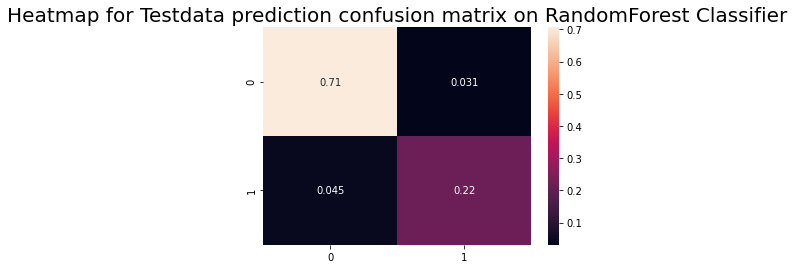

In [50]:
plt.title("Heatmap for Testdata prediction confusion matrix on RandomForest Classifier", fontsize =20)
sns.heatmap(confusion_matrix(y_test, y_pred)/np.sum(confusion_matrix(y_test, y_pred)), annot=True)

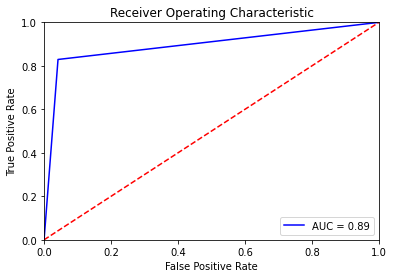

In [51]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# XGB

In [54]:
from xgboost import XGBClassifier

In [55]:
model = XGBClassifier(random_state=42,learning_rate =0.1,
 n_estimators=1000,
 max_depth=50,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [56]:
y_pred=model.predict(x_test)

In [57]:
from sklearn.metrics import accuracy_score

In [59]:
accuracy_score(y_test, y_pred)

0.9211397422339154

In [60]:
print('AUC: ', roc_auc_score(y_test, y_pred))


AUC:  0.8892042525531392


In [61]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     85742
           1       0.87      0.82      0.85     30565

    accuracy                           0.92    116307
   macro avg       0.90      0.89      0.90    116307
weighted avg       0.92      0.92      0.92    116307

[[82014  3728]
 [ 5444 25121]]


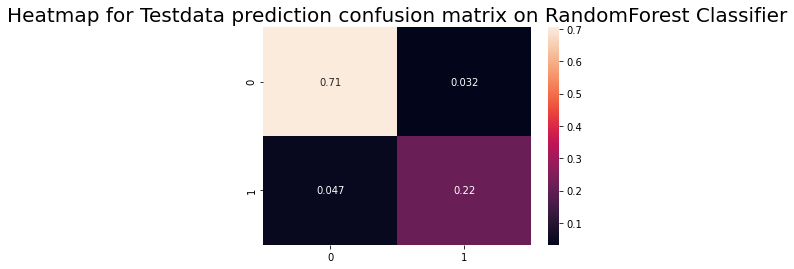

In [62]:
plt.title("Heatmap for Testdata prediction confusion matrix on RandomForest Classifier", fontsize =20)
sns.heatmap(confusion_matrix(y_test, y_pred)/np.sum(confusion_matrix(y_test, y_pred)), annot=True)

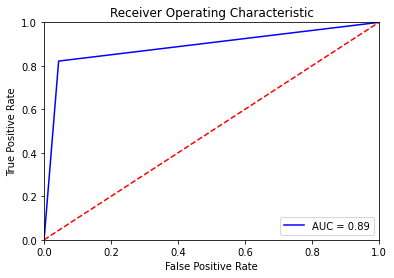

In [63]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [65]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test,y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.76


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

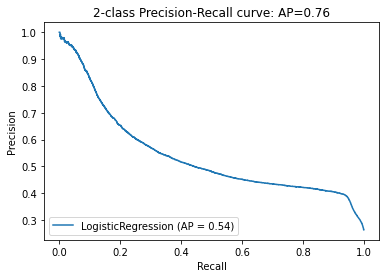

In [66]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(logistic, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# Saving + Loading the Model  and predicting on Test data

In [67]:
filename = '/content/drive/MyDrive/Spoiler_alert_model/Spoiler_alert_randomforest.sav'



In [68]:
pickle.dump(model, open(filename, 'wb'))

In [69]:
# load the model from disk
loaded_model_randomforest= pickle.load(open(filename, 'rb'))


In [70]:
test

,review_date,movie_id,user_id,is_spoiler,review_text,userrating,review_summary,plot_summary,duration,genre,actualrating,release_date,plot_synopsis,days_elapsed,word_count,spoiltext,msr,usr,gsr,distance_plot
179775,2015-03-10,23672,ur50489624,1,in which human beings ditch their bodies for s...,6,"In CHAPPiE, Sony Corporation imagines a world ...",in johannesburg the police department reduced ...,2h,"['Action', 'Crime', 'Drama']",6.8,2015-03-06,Set in an undeterminate year of the near futur...,4,191,0,0.302003,1.000000,0.592547,0.644434
322505,2001-07-19,19822,ur1254655,1,as good as it gets is definitely one of the be...,10,Wish that all movies were this professional,new york city melvin udall a cranky bigoted ob...,2h 19min,"['Comedy', 'Drama', 'Romance']",7.7,1997-12-25,"The entire movie takes place in New York City,...",1302,326,0,0.160428,0.250000,0.715963,1.221773
547841,2009-08-22,36608,ur21918998,0,this is in my mind exactly what this film will...,8,cult classic,in a massive star ship bearing a bedraggled al...,1h 52min,"['Sci-Fi', 'Thriller']",8.0,2009-08-14,The film opens with a documentary-style series...,8,418,0,0.370572,0.000000,0.682420,1.338364
95023,2015-03-07,82846,ur1773414,0,i had never read the book nor knew much about ...,6,it was too predictable,hazel and augustus are two teenagers who share...,2h 6min,"['Drama', 'Romance']",7.8,2014-06-06,A teenage girl named Hazel Grace Lancaster (Sh...,274,196,0,0.367942,0.100000,0.500361,0.821251
141094,2013-06-01,54876,ur18374320,0,life of pi is one of those everyday masterpiec...,7,Exhilarating and gorgeous in many ways,in canada a writer visits the indian storytell...,2h 7min,"['Adventure', 'Drama', 'Fantasy']",7.9,2012-11-21,"Pi Patel (Irrfan Khan), an immigrant from Pond...",192,210,0,0.339360,0.169014,0.789834,1.022281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564384,2006-03-30,17509,ur3583729,1,there are many kinds of films there are the fe...,3,A Travesty,the classic story of romeo and juliet set in a...,2h,"['Drama', 'Romance']",6.8,1996-11-01,The story revolves around three families from ...,3436,385,0,0.215789,1.000000,0.782492,0.470357
23529,2005-10-24,3639,ur4888011,0,in most cases aladdin would just be another di...,10,I'm losin' to a rug!,aladdin is a poor street urchin who spends his...,1h 30min,"['Animation', 'Adventure', 'Comedy']",8.0,1992-11-25,"The film starts with a street peddler, guiding...",4716,104,0,0.267327,0.063380,0.256906,0.443303
579858,2006-10-26,55267,ur2898779,1,i ve always enjoyed this remake i went back an...,9,the dichotomy of women,self made billionaire thomas crown is bored of...,1h 53min,"['Crime', 'Romance', 'Thriller']",6.8,1999-08-06,John McTiernan did a great job directing this ...,2638,169,0,0.108553,1.000000,0.591610,0.309928
509833,2005-09-11,60486,ur3364470,0,back in medieval times we in the uk had these ...,2,Church service,john constantine is approached by det angela d...,2h 1min,"['Drama', 'Fantasy', 'Horror']",7.0,2005-02-18,John Constantine (Keanu Reeves) was born with ...,205,188,0,0.198895,0.000000,0.215601,0.721353


In [71]:
testdata=test[['days_elapsed','word_count','spoiltext','usr','msr','gsr','distance_plot','actualrating']].values

In [72]:
testy=test[['is_spoiler']].values

In [73]:
rfpred=loaded_model_randomforest.predict(testdata)

In [74]:
resultrf = loaded_model_randomforest.score(testdata, testy)
print(resultrf)

0.7572357461443388


In [75]:
roc_auc_score(testy, rfpred)


0.835163406303059

In [76]:
print(classification_report(testy, rfpred))
print(confusion_matrix(testy, rfpred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     68593
           1       0.52      1.00      0.68     24452

    accuracy                           0.76     93045
   macro avg       0.76      0.84      0.74     93045
weighted avg       0.87      0.76      0.77     93045

[[46019 22574]
 [   14 24438]]


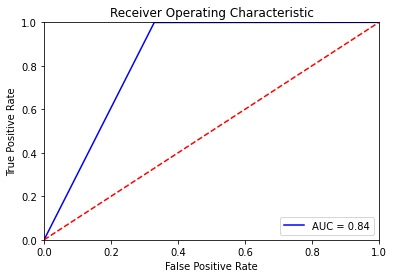

In [77]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(testy, rfpred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()